In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from scipy.stats import zscore

In [2]:
df = pd.read_csv('CSV_Files/Ledger_Metadata_2024-11-30.csv')

df = df[['Ledger_Number', 'Row_Count']]

df['Ledger_Number_Scaled'] = (df['Ledger_Number'] // 500)
df['Ledger_Number_Scaled'] -= df['Ledger_Number_Scaled'].min()

df.sort_values(by='Ledger_Number_Scaled')
df.head()

,Ledger_Number,Row_Count,Ledger_Number_Scaled
0,89899995,32,0
1,89900495,27,1
2,89900995,26,2
3,89901495,45,3
4,89901995,31,4


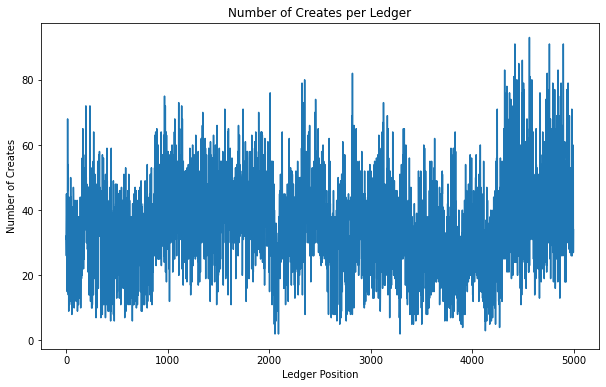

In [3]:
plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Number_Scaled'], df['Row_Count'])

plt.xlabel('Ledger Position')
plt.ylabel('Number of Creates')
plt.title('Number of Creates per Ledger')

plt.show()

## No visible relationship any which way, possible high variance
## What about creates related to XRP?

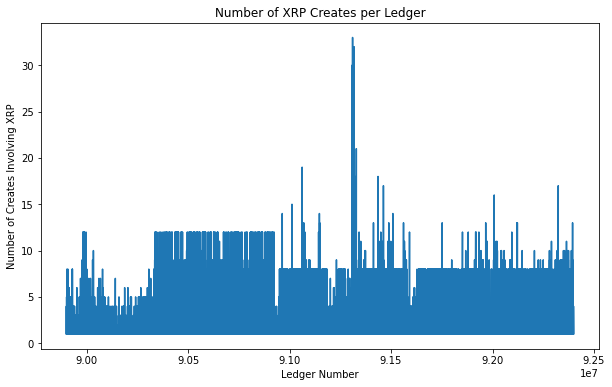

In [4]:
df = pd.read_csv('CSV_Files/Ledger_Currency_Pairs_2024-11-30.csv')
df_xrp = df[(df['Gets_Currency_Code'] == 'XRP') | (df['Pays_Currency_Code'] == 'XRP')]
df_xrp_grouped = df_xrp.groupby(df['Ledger_Number']).agg(
    Row_Count=('Row_Count', 'sum')
)

plt.figure(figsize=(10, 6))
plt.plot(df['Ledger_Number'], df['Row_Count'])

plt.xlabel('Ledger Number')
plt.ylabel('Number of Creates Involving XRP')
plt.title('Number of XRP Creates per Ledger')

plt.show()

## Findings: Once again no visible relationship, could be worth investingating small section with high outliers
## What about the amount of XRP related in these trades over 500 block intervals?

In [5]:
# Build transformation function
def transform_row(row):
    if row['Gets_Currency_Code'] == 'XRP':
        return {
            'Ledger_Number': row['Ledger_Number'],

            'XRP_Code': row['Gets_Currency_Code'],
            'XRP_Amount': row['Gets_Count_sum'],

            'Traded_currency_Code': row['Pays_Currency_Code'],
            'Traded_Currency_Amount': row['Pays_Count_sum']
        }
    
    elif row['Pays_Currency_Code'] == 'XRP':
        return {
            'Ledger_Number': row['Ledger_Number'],

            'XRP_Code': row['Pays_Currency_Code'],
            'XRP_Amount': row['Pays_Count_sum'],

            'Traded_currency_Code': row['Gets_Currency_Code'],
            'Traded_Currency_Amount': row['Gets_Count_sum']
        }
    else:
        print('Error')
        raise ValueError('Invalid row entry')


transformed_data = [transform_row(row) for _, row in df_xrp.iterrows()]
df_xrp = pd.DataFrame(transformed_data)

df_xrp['Ledger_Number_Scaled'] = (df_xrp['Ledger_Number'] // 500)
df_xrp['Ledger_Number_Scaled'] -= df_xrp['Ledger_Number_Scaled'].min()

df_xrp.sort_values(by='Ledger_Number_Scaled')
df_xrp.head()

,Ledger_Number,XRP_Code,XRP_Amount,Traded_currency_Code,Traded_Currency_Amount,Ledger_Number_Scaled
0,89899995,XRP,4.510000e+07,434F524500000000000000000000000000000000,316.088315,0
1,89899995,XRP,2.000000e+11,5553444300000000000000000000000000000000,97786.724800,0
2,89899995,XRP,2.000000e+11,5553445400000000000000000000000000000000,97478.165600,0
3,89899995,XRP,1.000000e+00,58434F5245000000000000000000000000000000,0.000089,0
4,89899995,XRP,1.000000e+07,5A52505900000000000000000000000000000000,1348.949532,0


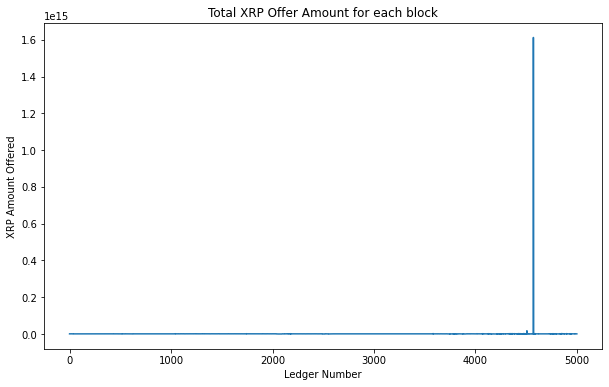

In [6]:
df_xrp_only = df_xrp.groupby(['Ledger_Number', 'Ledger_Number_Scaled', 'XRP_Code']).agg(
    XRP_Amount=('XRP_Amount', 'sum')
).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(df_xrp_only['Ledger_Number_Scaled'], df_xrp_only['XRP_Amount'])

plt.xlabel('Ledger Number')
plt.ylabel('XRP Amount Offered')
plt.title('Total XRP Offer Amount for each block')

plt.show()

### Find and Remove extreme outliers

In [7]:
df_xrp_only['z_score'] = zscore(df_xrp_only['XRP_Amount'], nan_policy='omit')
df_xrp_only.sort_values(by='z_score', ascending=False).head(10)


,Ledger_Number,Ledger_Number_Scaled,XRP_Code,XRP_Amount,z_score
4554,92185495,4571,XRP,1.612689e+15,70.567375
4490,92153495,4507,XRP,1.745907e+13,0.720496
4456,92136495,4473,XRP,2.354971e+12,0.059165
4835,92325995,4852,XRP,2.317040e+12,0.057504
4325,92070995,4342,XRP,2.265321e+12,0.055240
4349,92082995,4366,XRP,2.230023e+12,0.053694
3566,91691495,3583,XRP,2.215662e+12,0.053066
4559,92187995,4576,XRP,2.198679e+12,0.052322
4881,92349495,4899,XRP,2.133231e+12,0.049456
4409,92112995,4426,XRP,2.056149e+12,0.046081


In [8]:
df_xrp_only_cleaned = df_xrp_only[df_xrp_only['z_score'].abs() <=70]
df_xrp_only_cleaned['z_score'] = zscore(df_xrp_only_cleaned['XRP_Amount'], nan_policy='omit')
df_xrp_only_cleaned.sort_values(by='z_score', ascending=False).head(10)

<ipython-input-8-8a5d5405930a>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_xrp_only_cleaned['z_score'] = zscore(df_xrp_only_cleaned['XRP_Amount'], nan_policy='omit')


,Ledger_Number,Ledger_Number_Scaled,XRP_Code,XRP_Amount,z_score
4490,92153495,4507,XRP,1.745907e+13,46.452750
4456,92136495,4473,XRP,2.354971e+12,4.636819
4835,92325995,4852,XRP,2.317040e+12,4.531807
4325,92070995,4342,XRP,2.265321e+12,4.388622
4349,92082995,4366,XRP,2.230023e+12,4.290898
3566,91691495,3583,XRP,2.215662e+12,4.251139
4559,92187995,4576,XRP,2.198679e+12,4.204123
4881,92349495,4899,XRP,2.133231e+12,4.022927
4409,92112995,4426,XRP,2.056149e+12,3.809525
4830,92323495,4847,XRP,2.046415e+12,3.782577


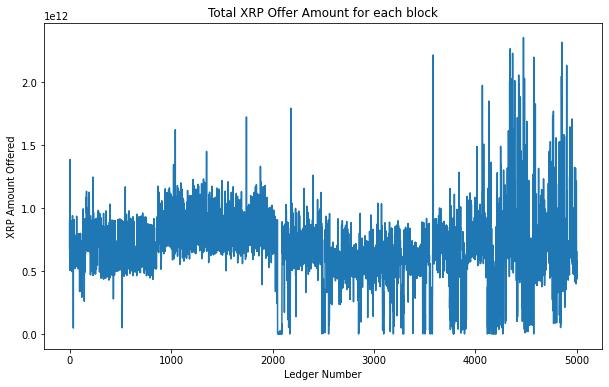

In [9]:
df_xrp_only_cleaned = df_xrp_only_cleaned[df_xrp_only_cleaned['z_score'].abs() <=40]

plt.figure(figsize=(10, 6))
plt.plot(df_xrp_only_cleaned['Ledger_Number_Scaled'], df_xrp_only_cleaned['XRP_Amount'])

plt.xlabel('Ledger Number')
plt.ylabel('XRP Amount Offered')
plt.title('Total XRP Offer Amount for each block')

plt.show()

## Findings: No visible relationship, maybe an increase in maximums and variance?
## What about XRP trade amounts in relation to other currencies over 500 block intervals?

In [10]:
summary = df_xrp.groupby('Traded_currency_Code', as_index=False).agg(
    total_XRP_Amount=('XRP_Amount', 'sum')
)


# Combine these changes/fluctuations to the fluctuations of XRP/Dollar value